In [1]:
from data import build_dataset, load_and_preprocess_image, build_dataset_attention
import fire
import math
from model import get_model, get_global_model
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
global_model = get_global_model()
global_model.load_weights("model/checkpoint.ckpt")

heatmap_model = tf.keras.models.Model(inputs = global_model.layers[0].input, 
                                      outputs = global_model.layers[0].get_layer('conv5_block3_out').output)
local_model = get_global_model()
local_model.load_weights("model/AG-CNN-FINAL/checkpoint.ckpt")
TEST_CSV = "data/data/processed_test.csv"
test_csv = pd.read_csv(TEST_CSV)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
____________

In [3]:
TRAIN_CSV = "data/data/processed_attention_train.csv"
VALID_CSV = "data/data/processed_attention_valid.csv"
train_csv = pd.read_csv(TRAIN_CSV)
valid_csv = pd.read_csv(VALID_CSV)


In [4]:
test_csv

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,...,Fracture,Support Devices,AttentionPath,global_prediction,local_prediction,fusion_prediction,global_prediction_proba,local_prediction_proba,fusion_prediction_proba,attentionPathFinal
0,0,0,0,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,73,Frontal,AP,0.0,1.0,...,0.0,0.0,../cs221/CheXpert-v1.0-small/valid/patient6454...,1,1,0.880911,0.995097,0.596681,0.685874,../cs221/CheXpert-v1.0-small/valid/patient6454...
1,1,1,1,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,70,Frontal,PA,0.0,0.0,...,0.0,1.0,../cs221/CheXpert-v1.0-small/valid/patient6454...,0,0,0.034735,0.391615,0.044540,0.021616,../cs221/CheXpert-v1.0-small/valid/patient6454...
2,2,2,2,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,70,Lateral,NaN,0.0,0.0,...,0.0,1.0,../cs221/CheXpert-v1.0-small/valid/patient6454...,0,0,0.001383,0.493978,0.245433,0.127721,../cs221/CheXpert-v1.0-small/valid/patient6454...
3,3,3,3,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,85,Frontal,AP,0.0,1.0,...,0.0,0.0,../cs221/CheXpert-v1.0-small/valid/patient6454...,1,0,0.944142,0.997578,0.127951,0.595326,../cs221/CheXpert-v1.0-small/valid/patient6454...
4,4,4,4,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Female,42,Frontal,AP,1.0,0.0,...,0.0,0.0,../cs221/CheXpert-v1.0-small/valid/patient6454...,1,0,0.099209,0.705098,0.095894,0.062712,../cs221/CheXpert-v1.0-small/valid/patient6454...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,229,229,229,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Female,57,Frontal,AP,0.0,0.0,...,0.0,1.0,../cs221/CheXpert-v1.0-small/valid/patient6473...,1,0,0.959133,0.999907,0.306117,0.742849,../cs221/CheXpert-v1.0-small/valid/patient6473...
230,230,230,230,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,65,Frontal,AP,0.0,0.0,...,0.0,1.0,../cs221/CheXpert-v1.0-small/valid/patient6473...,1,0,0.473019,0.956878,0.244868,0.472319,../cs221/CheXpert-v1.0-small/valid/patient6473...
231,231,231,231,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,71,Frontal,AP,0.0,1.0,...,0.0,1.0,../cs221/CheXpert-v1.0-small/valid/patient6473...,1,0,0.199063,0.969642,0.294335,0.415426,../cs221/CheXpert-v1.0-small/valid/patient6473...
232,232,232,232,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Female,45,Frontal,AP,0.0,1.0,...,0.0,0.0,../cs221/CheXpert-v1.0-small/valid/patient6473...,1,0,0.912982,0.999464,0.695023,0.334668,../cs221/CheXpert-v1.0-small/valid/patient6473...


In [11]:
def getHeatmap(image, thresh=0.2):
    prediction = global_model.predict(tf.expand_dims(image, 0))
    conv_output = heatmap_model.predict(tf.expand_dims(image, 0))[0]
    cam = np.zeros(dtype = np.float32, shape = conv_output.shape[0:2])
    for i, w in enumerate(global_model.layers[-1].get_weights()[0]):
        cam += w * conv_output[:, :, i]
    cam /= np.max(cam)
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam < thresh)] = 0
    return heatmap

def getContours(heatmap):
    imgray = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours, hierarchy

def getAttentionArea(path):
    image = load_and_preprocess_image(path)
    heatmap = getHeatmap(image)
    contours, hierarchy = getContours(heatmap)
    maxArea = 0
    X = None
    Y = None
    W = None
    H = None
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > maxArea:
            maxArea = area
            X = x
            Y = y
            W = w
            H = h
    
    cx = X + W // 2
    cy = Y + H // 2
    half_len = min(50, 224-cx+1, cx-0, 224-cy+1, cy-0)
    np_image = image.numpy() * 255
    cropped_np_image = np_image[cy-half_len:cy+half_len, cx-half_len:cx+half_len]
    resized = cv2.resize(cropped_np_image, (224,224), interpolation = cv2.INTER_AREA)
    new_path = "../cs221/" + path[20:-4] + "_attention_final.jpg"
    cv2.imwrite(new_path, resized)
    print(new_path + " is done! half_len=" + str(half_len) + " cx=" + str(cx) + " cy=" + str(cy))
    return new_path

In [9]:
test_csv["attentionPathFinal"] = test_csv.Path.apply(getAttentionArea)

../cs221/CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=134 cy=131
../cs221/CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal_attention_final.jpg is done! half_len=21 cx=204 cy=56
../cs221/CheXpert-v1.0-small/valid/patient64542/study1/view2_lateral_attention_final.jpg is done! half_len=50 cx=74 cy=154
../cs221/CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=88 cy=145
../cs221/CheXpert-v1.0-small/valid/patient64544/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=166 cy=112
../cs221/CheXpert-v1.0-small/valid/patient64545/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=112 cy=110
../cs221/CheXpert-v1.0-small/valid/patient64546/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=107 cy=141
../cs221/CheXpert-v1.0-small/valid/patient64547/study1/view1_frontal_attention_final.jpg is done! half_len=47 cx=178 cy=177
../cs221/Ch

../cs221/CheXpert-v1.0-small/valid/patient64590/study1/view2_lateral_attention_final.jpg is done! half_len=50 cx=62 cy=144
../cs221/CheXpert-v1.0-small/valid/patient64591/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=158 cy=80
../cs221/CheXpert-v1.0-small/valid/patient64592/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=128 cy=118
../cs221/CheXpert-v1.0-small/valid/patient64593/study1/view1_frontal_attention_final.jpg is done! half_len=44 cx=170 cy=181
../cs221/CheXpert-v1.0-small/valid/patient64594/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=140 cy=159
../cs221/CheXpert-v1.0-small/valid/patient64594/study1/view2_lateral_attention_final.jpg is done! half_len=35 cx=79 cy=190
../cs221/CheXpert-v1.0-small/valid/patient64595/study1/view1_frontal_attention_final.jpg is done! half_len=39 cx=186 cy=112
../cs221/CheXpert-v1.0-small/valid/patient64595/study1/view2_lateral_attention_final.jpg is done! half_len=38 cx=84 cy=187
../cs221/Che

../cs221/CheXpert-v1.0-small/valid/patient64643/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=112 cy=124
../cs221/CheXpert-v1.0-small/valid/patient64644/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=130 cy=111
../cs221/CheXpert-v1.0-small/valid/patient64645/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=157 cy=122
../cs221/CheXpert-v1.0-small/valid/patient64646/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=130 cy=122
../cs221/CheXpert-v1.0-small/valid/patient64647/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=130 cy=146
../cs221/CheXpert-v1.0-small/valid/patient64648/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=100 cy=138
../cs221/CheXpert-v1.0-small/valid/patient64649/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=74 cy=65
../cs221/CheXpert-v1.0-small/valid/patient64650/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=120 cy=130
../cs221/C

../cs221/CheXpert-v1.0-small/valid/patient64708/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=162 cy=132
../cs221/CheXpert-v1.0-small/valid/patient64709/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=107 cy=113
../cs221/CheXpert-v1.0-small/valid/patient64710/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=157 cy=146
../cs221/CheXpert-v1.0-small/valid/patient64711/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=127 cy=135
../cs221/CheXpert-v1.0-small/valid/patient64712/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=111 cy=98
../cs221/CheXpert-v1.0-small/valid/patient64713/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=115 cy=133
../cs221/CheXpert-v1.0-small/valid/patient64714/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=94 cy=152
../cs221/CheXpert-v1.0-small/valid/patient64715/study1/view1_frontal_attention_final.jpg is done! half_len=50 cx=158 cy=144
../cs221/C

In [12]:
test_csv.to_csv(TEST_CSV, index=False)

In [18]:
global_dataset = build_dataset(TEST_CSV).prefetch(32).batch(32)
global_predictions = global_model.predict(global_dataset, steps=math.ceil(len(test_csv) / float(32)))

In [14]:
local_dataset = build_dataset_attention(TEST_CSV).prefetch(32).batch(32)
local_predictions = local_model.predict(local_dataset, steps=math.ceil(len(test_csv) / float(32)))

In [16]:
test_csv['global_prediction_proba'] = global_predictions
test_csv['local_prediction_proba'] = local_predictions

In [19]:
IMG_SHAPE = [224, 224, 3]
res_net_global = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
res_net_global.set_weights(global_model.layers[0].get_weights())
res_net_global.trainable = False
for layer in res_net_global.layers:
    layer._name = layer._name + "_global"

res_net_local = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
res_net_local.set_weights(local_model.layers[0].get_weights())
res_net_local.trainable = False
for layer in res_net_global.layers:
    layer._name = layer._name + "_local"

global_average_layer_global = tf.keras.layers.GlobalAveragePooling2D()
global_average_layer_local = tf.keras.layers.GlobalAveragePooling2D()
global_pooling_model = tf.keras.Sequential([res_net_global, global_average_layer_global])
local_pooling_model = tf.keras.Sequential([res_net_local, global_average_layer_local])


In [20]:
global_pooling = global_pooling_model.predict(global_dataset, steps=math.ceil(len(test_csv) / float(32)))
local_pooling = local_pooling_model.predict(local_dataset, steps=math.ceil(len(test_csv) / float(32)))


In [21]:
concat = np.concatenate((global_pooling, local_pooling), axis=1)
print(concat.shape)

(234, 4096)


In [22]:
x = tf.keras.Input(shape=(4096,))
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)
fusion_model = tf.keras.Model(x, y)
fusion_model.load_weights("model/AG-CNN-Fusion-Final-400Epoch/checkpoint.ckpt")

In [23]:
fusion_predictions = fusion_model.predict(concat)

In [25]:
test_csv["fusion_prediction_proba"] = fusion_predictions

In [26]:
test_csv.to_csv("data/data/processed_test.csv", index=False)

In [29]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(test_csv["Cardiomegaly"], test_csv["global_prediction_proba"]))
print(roc_auc_score(test_csv["Cardiomegaly"], test_csv["local_prediction_proba"]))
print(roc_auc_score(test_csv["Cardiomegaly"], test_csv["fusion_prediction_proba"]))

0.8383238837703756
0.7965095676824947
0.8374379872430899


In [30]:
from sklearn.metrics import average_precision_score
print(average_precision_score(test_csv["Cardiomegaly"], test_csv["global_prediction_proba"]))
print(average_precision_score(test_csv["Cardiomegaly"], test_csv["local_prediction_proba"]))
print(average_precision_score(test_csv["Cardiomegaly"], test_csv["fusion_prediction_proba"]))


0.6219614459313235
0.5658698191908832
0.6578065030261477


In [32]:
def get_cm(test_csv, pred_colname, gt_colname="Cardiomegaly", thresh = 0.5):
    cm = confusion_matrix(test_csv[gt_colname].astype(int), (test_csv[pred_colname] > thresh).astype(int))
    cm_result = pd.DataFrame(cm, index=["GT_OK", "GT_NG"], columns=["PRED_OK", "PRED_NG"])
    print(cm_result)

In [33]:
get_cm(test_csv, pred_colname="global_prediction_proba")
get_cm(test_csv, pred_colname="local_prediction_proba")
get_cm(test_csv, pred_colname="fusion_prediction_proba")

       PRED_OK  PRED_NG
GT_OK       19      147
GT_NG        0       68
       PRED_OK  PRED_NG
GT_OK      122       44
GT_NG       21       47
       PRED_OK  PRED_NG
GT_OK       87       79
GT_NG        4       64


In [3]:
FP = test_csv[test_csv.Cardiomegaly == 0.0][test_csv.global_prediction_proba > 0.5][test_csv.fusion_prediction_proba < 0.5].reset_index(drop=True)
#FN = test_csv[test_csv.Cardiomegaly == 1.0][test_csv.global_prediction_proba < 0.5][test_csv.fusion_prediction_proba > 0.5].reset_index(drop=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [4]:
FP

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,...,Fracture,Support Devices,AttentionPath,global_prediction,local_prediction,fusion_prediction,global_prediction_proba,local_prediction_proba,fusion_prediction_proba,attentionPathFinal
0,4,4,4,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Female,42,Frontal,AP,1.0,0.0,...,0.0,0.0,../cs221/CheXpert-v1.0-small/valid/patient6454...,1,0,0.099209,0.705098,0.095894,0.062712,../cs221/CheXpert-v1.0-small/valid/patient6454...
1,5,5,5,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Female,55,Frontal,AP,0.0,1.0,...,0.0,0.0,../cs221/CheXpert-v1.0-small/valid/patient6454...,1,1,0.511060,0.992524,0.379250,0.104112,../cs221/CheXpert-v1.0-small/valid/patient6454...
2,8,8,8,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,59,Frontal,PA,0.0,0.0,...,0.0,0.0,../cs221/CheXpert-v1.0-small/valid/patient6454...,1,0,0.065928,0.707518,0.054606,0.089239,../cs221/CheXpert-v1.0-small/valid/patient6454...
3,9,9,9,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,59,Lateral,NaN,0.0,0.0,...,0.0,0.0,../cs221/CheXpert-v1.0-small/valid/patient6454...,1,0,0.484223,0.885293,0.044450,0.122854,../cs221/CheXpert-v1.0-small/valid/patient6454...
4,12,12,12,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,34,Frontal,AP,0.0,0.0,...,0.0,1.0,../cs221/CheXpert-v1.0-small/valid/patient6455...,1,0,0.001205,0.519789,0.084423,0.080044,../cs221/CheXpert-v1.0-small/valid/patient6455...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,220,220,220,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Female,59,Frontal,AP,1.0,0.0,...,0.0,0.0,../cs221/CheXpert-v1.0-small/valid/patient6472...,1,0,0.129152,0.943742,0.273510,0.228900,../cs221/CheXpert-v1.0-small/valid/patient6472...
65,224,224,224,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,60,Frontal,AP,0.0,0.0,...,0.0,1.0,../cs221/CheXpert-v1.0-small/valid/patient6473...,1,0,0.005108,0.878479,0.091489,0.027236,../cs221/CheXpert-v1.0-small/valid/patient6473...
66,228,228,228,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Female,63,Frontal,AP,0.0,0.0,...,0.0,0.0,../cs221/CheXpert-v1.0-small/valid/patient6473...,1,0,0.026034,0.649105,0.174633,0.280180,../cs221/CheXpert-v1.0-small/valid/patient6473...
67,230,230,230,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,65,Frontal,AP,0.0,0.0,...,0.0,1.0,../cs221/CheXpert-v1.0-small/valid/patient6473...,1,0,0.473019,0.956878,0.244868,0.472319,../cs221/CheXpert-v1.0-small/valid/patient6473...


In [5]:
FP = test_csv[test_csv.Cardiomegaly == 1.0][test_csv.fusion_prediction_proba < 0.5][test_csv.global_prediction_proba > 0.5].reset_index(drop=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [6]:
FP

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,...,Fracture,Support Devices,AttentionPath,global_prediction,local_prediction,fusion_prediction,global_prediction_proba,local_prediction_proba,fusion_prediction_proba,attentionPathFinal
0,42,42,42,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,38,Frontal,AP,0.0,1.0,...,0.0,0.0,../cs221/CheXpert-v1.0-small/valid/patient6457...,1,0,0.040042,0.892596,0.276892,0.203019,../cs221/CheXpert-v1.0-small/valid/patient6457...
1,96,96,96,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Female,64,Frontal,AP,0.0,1.0,...,0.0,1.0,../cs221/CheXpert-v1.0-small/valid/patient6461...,1,0,0.023250,0.644526,0.266520,0.248505,../cs221/CheXpert-v1.0-small/valid/patient6461...
2,138,138,138,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Female,23,Frontal,AP,0.0,1.0,...,0.0,0.0,../cs221/CheXpert-v1.0-small/valid/patient6464...,1,0,0.457715,0.979474,0.443428,0.151005,../cs221/CheXpert-v1.0-small/valid/patient6464...
3,231,231,231,gs://cs221_chexpert/CheXpert-v1.0-small/valid/...,Male,71,Frontal,AP,0.0,1.0,...,0.0,1.0,../cs221/CheXpert-v1.0-small/valid/patient6473...,1,0,0.199063,0.969642,0.294335,0.415426,../cs221/CheXpert-v1.0-small/valid/patient6473...


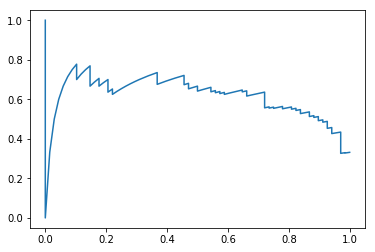

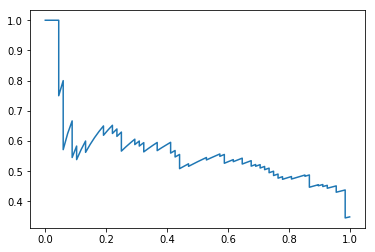

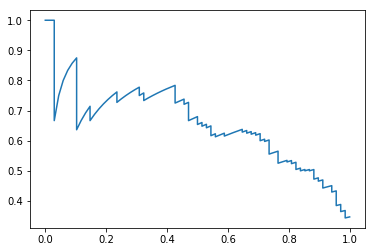

<Figure size 432x288 with 0 Axes>

In [5]:
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
def plotPrecisionRecall(test_csv, pred_colname, gt_colname="Cardiomegaly"):
    precision, recall, thresholds = precision_recall_curve(test_csv[gt_colname].astype(int), test_csv[pred_colname])
    plt.plot(recall, precision)
    plt.show()
    plt.clf()
plotPrecisionRecall(test_csv, pred_colname="global_prediction_proba")
plotPrecisionRecall(test_csv, pred_colname="local_prediction_proba")
plotPrecisionRecall(test_csv, pred_colname="fusion_prediction_proba")


In [6]:
index = 10
df = FN
tf_image = load_and_preprocess_image(df.loc[10, 'Path'])
heatmap= getHeatmap(tf_image, global_model, heatmap_model)


234

In [9]:
def drawBoxes(path):
    image = load_and_preprocess_image(path)
    heatmap =  getHeatmap(image)
    contours, hierarchy = getContours(heatmap)
    maxArea = 0
    X = None
    Y = None
    W = None
    H = None
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > maxArea:
            maxArea = area
            X = x
            Y = y
            W = w
            H = h
    
    cx = X + W // 2
    cy = Y + H // 2
    half_len = min(50, 224-cx+1, cx-0, 224-cy+1, cy-0)
    imageNumpy = image.numpy() * 255
    cv2.rectangle(heatmap, (cx-half_len, cy-half_len), (cx+half_len, cy+half_len), (255, 0, 0), 2)
    cv2.rectangle(imageNumpy, (cx-half_len, cy-half_len), (cx+half_len, cy+half_len), (255, 0, 0), 2)

    return image.numpy()*255, heatmap, imageNumpy

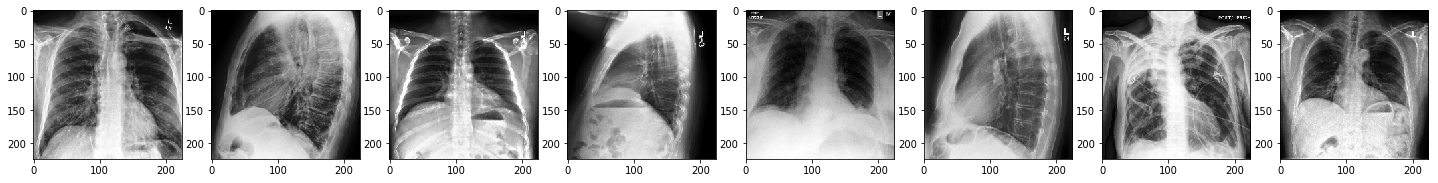

In [100]:
bad = [3,4,9,10,24,33,36,46]
fig, ax = plt.subplots(1, 8, figsize=(25,8))
count = 0
for i in bad:
    sample = FP.loc[i, :]
    x, y, z = drawBoxes(sample['Path'])
    ax[count].imshow(x.astype('uint8'))
    count += 1
fig.savefig("original_FP_final.png")

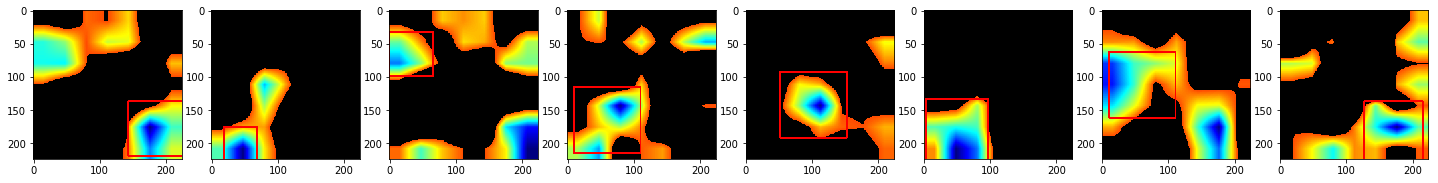

In [101]:
bad = [3,4,9,10,24,33,36,46]
fig, ax = plt.subplots(1, 8, figsize=(25,8))
count = 0
for i in bad:
    sample = FP.loc[i, :]
    x, y, z = drawBoxes(sample['Path'])
    ax[count].imshow(y.astype('uint8'))
    count += 1
fig.savefig("heatmap+box_FN_final.png")

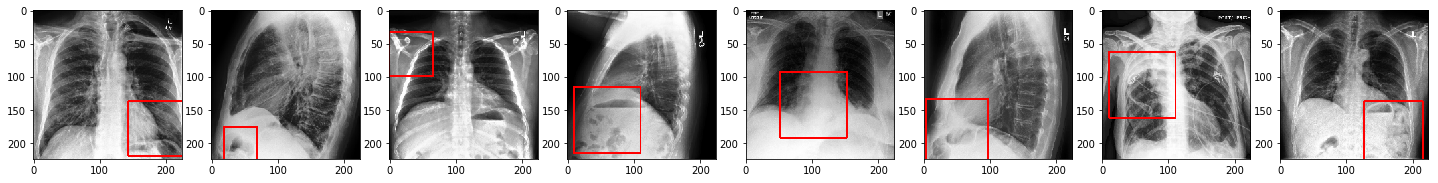

In [102]:
bad = [3,4,9,10,24,33,36,46]
fig, ax = plt.subplots(1, 8, figsize=(25,8))
count = 0
for i in bad:
    sample = FP.loc[i, :]
    x, y, z = drawBoxes(sample['Path'])
    ax[count].imshow(z.astype('uint8'))
    count += 1
fig.savefig("original+box_FN_final.png")

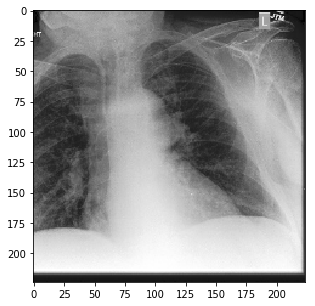

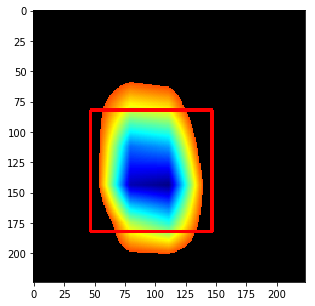

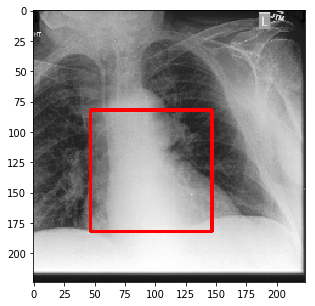

In [15]:
i=3
sample = FP.loc[i, :]
x, y, z = drawBoxes(sample['Path'])
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(x.astype('uint8'))
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(y.astype('uint8'))
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(z.astype('uint8'))


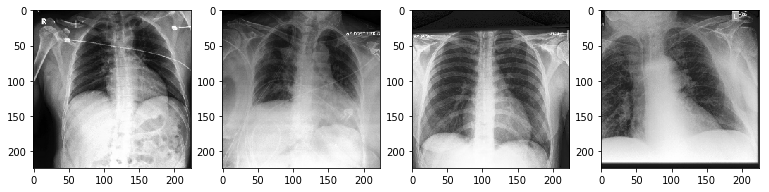

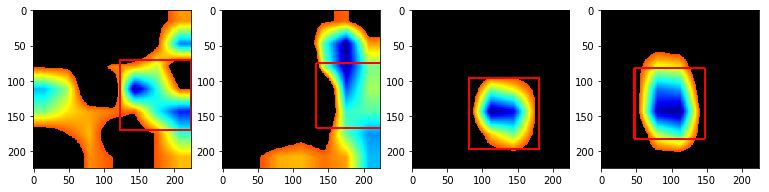

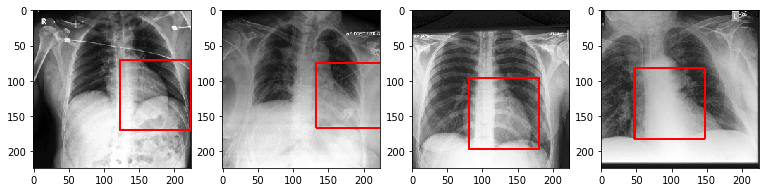

In [20]:
bad = [0, 1, 2, 3]
fig, ax = plt.subplots(1, 4, figsize=(13,4))
count = 0
for i in bad:
    sample = FP.loc[i, :]
    x, y, z = drawBoxes(sample['Path'])
    ax[count].imshow(x.astype('uint8'))
    count += 1
fig.savefig("original_FP_final_2.png")

fig, ax = plt.subplots(1, 4, figsize=(13,4))
count = 0
for i in bad:
    sample = FP.loc[i, :]
    x, y, z = drawBoxes(sample['Path'])
    ax[count].imshow(y.astype('uint8'))
    count += 1
fig.savefig("heatmap+box_FN_final_2.png")

fig, ax = plt.subplots(1, 4, figsize=(13,4))
count = 0
for i in bad:
    sample = FP.loc[i, :]
    x, y, z = drawBoxes(sample['Path'])
    ax[count].imshow(z.astype('uint8'))
    count += 1
fig.savefig("original+box_FN_final_2.png")